<a href="https://www.kaggle.com/code/lucasbensaid/titanic-top-4?scriptVersionId=119134697" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Titanic Project

- The goal of the project is to correctly predict if someone survived the Titanic shipwreck on April 15, 1912. 

- In this notebook, I follow a step-by-step workflow to show how I am working through the problem with deep details and visualizations.

**Best results : 79.904 % accuracy (Top 4%)**

<br>

### Workflow stages:


##### 1) Import data

##### 2) Exploratory data analysis (EDA)

##### 3) Feature engineering 1

##### 4) Feature engineering 2

##### 5) Modeling

##### 7) Submission


# Import data

In [1]:
%%capture
!pip install lazypredict

# Scikit-learn packages
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score

# import models
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
import xgboost 
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

# Lazy Predict packages
from lazypredict.Supervised import LazyRegressor,LazyClassifier

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import Image



# Setting up max columns displayed to 100
pd.options.display.max_columns = 10

In [2]:
# Our datasets
directory_to_extract_to = '/kaggle/input/titanic'
df_train = pd.read_csv(directory_to_extract_to+'/train.csv')
df_test = pd.read_csv(directory_to_extract_to+'/test.csv')

# We concatenate these datasets to run certain operations on both.
dfs = [('train',df_train), ('test',df_test)]
df_full = pd.concat([df_train, df_test], axis = 0).reset_index(drop=True)

# EDA

### Datasets overview

We check our data types & null counts 




In [3]:
for df in dfs:
  print(df[0],':\n')
  print(df[1].info(),'\n\n\n')

train :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None 



test :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-nul

In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,...,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,...,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,...,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,...,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,...,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,...,0,373450,8.05,NaN,S


### Nan Values

In [5]:
# Count / percentage of Nan values per columns
for df in dfs:
  pr = pd.Series(df[1].isna().sum() / len(df[1]), name='percent')
  nb = pd.Series(df[1].isna().sum(), name='count')
  
  print(df[0],':\n')

  display(pd.concat([nb, pr],axis =1))
  print('\n\n')

train :



,count,percent
PassengerId,0,0.00
Survived,0,0.00
Pclass,0,0.00
Name,0,0.00
Sex,0,0.00
Age,177,0.20
SibSp,0,0.00
Parch,0,0.00
Ticket,0,0.00
Fare,0,0.00





test :



,count,percent
PassengerId,0,0.00
Pclass,0,0.00
Name,0,0.00
Sex,0,0.00
Age,86,0.21
SibSp,0,0.00
Parch,0,0.00
Ticket,0,0.00
Fare,1,0.00
Cabin,327,0.78


**Cabin** has more than 75% values in both datasets we will drop it

In [6]:
for df in dfs:
  df[1].drop('Cabin', axis = 1, inplace =True)

**Embarked** from train

From [link](https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html):

>"*Mrs Stone boarded the Titanic in Southampton on 10 April 1912 and was travelling in first class with her maid Amelie Icard. She occupied cabin B-28.*"


We will fill by 'S'

In [7]:
df_train.loc[df_train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,...,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,...,0,0,113572,80.00,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,...,0,0,113572,80.00,NaN


In [8]:
df_train.loc[df_train['Embarked'].isnull(), 'Embarked'] = 'S'

Next we will:

**Train**:

>Fill nan values of Age 

**Test**:

>Fill nan values of Age and Fare 


### Data types

Which features are categorical? numerical?

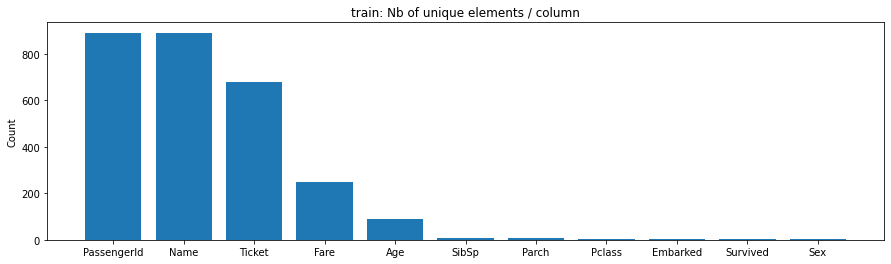



Unique element / column:


,number,percentage
PassengerId,891,1.00
Name,891,1.00
Ticket,681,0.76
Fare,248,0.28
Age,88,0.10
SibSp,7,0.01
Parch,7,0.01
Pclass,3,0.00
Embarked,3,0.00
Survived,2,0.00


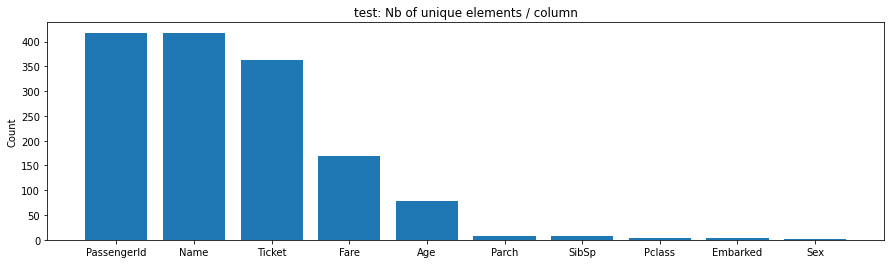



Unique element / column:


,number,percentage
PassengerId,418,1.00
Name,418,1.00
Ticket,363,0.87
Fare,169,0.40
Age,79,0.19
Parch,8,0.02
SibSp,7,0.02
Pclass,3,0.01
Embarked,3,0.01
Sex,2,0.00


In [9]:
for df in dfs:

  t = df[1].nunique().sort_values(ascending=False)

  plt.figure(figsize=(15,4))
  plt.title(f"{df[0]}: Nb of unique elements / column")
  plt.ylabel('Count')
  plt.bar(t.index, t.values)
  plt.show()

  nb = pd.Series(t, name = 'number')
  pr = pd.Series(t/len(df[1]), name = 'percentage')
  
  print('\n\nUnique element / column:')
  display(pd.concat([nb,pr], axis=1))
  print('\n\n')

**Numerical:**
- Discrete
> Parch, SibSp
- Continuous
> Fare, Age

**Categorical:**
- Nominal 
> Name, PassengerId, Ticket, Cabin, Embarked, Sex, Survived (*target*)


- Ordinal 
> Pclass

In [10]:
num_cols = ['Fare', 'Age']
num_cnt_cols = ['Parch', 'SibSp']
nominal_cols = ['Name', 'PassengerId', 'Ticket', 'Embarked', 'Sex']
ordinal_cols = ['Pclass']
target = ['Survived']

### Data distribution

#### Target distribution

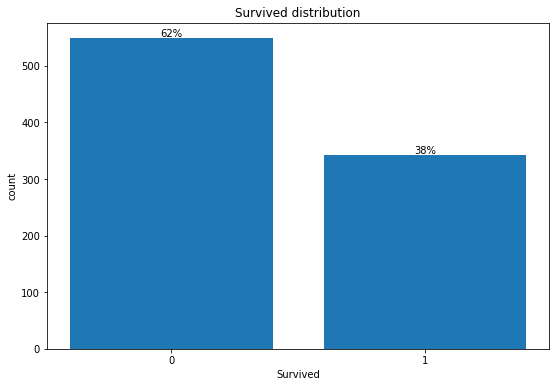

In [11]:
t = df_train['Survived'].value_counts(sort=False)

plt.figure(figsize=(9,6))
plt.bar(t.index.astype('str'), t)
plt.ylabel('count')
plt.xlabel('Survived')
plt.title('Survived distribution')


for i in t.index:
  plt.annotate("{0:.0f}%".format(t[i]*100/len(df_train)),xy=(i, t[i]) ,ha='center', va='bottom')
plt.show()

**Observation:**

- 38 % of the passenger survived

#### Numerical features distribution

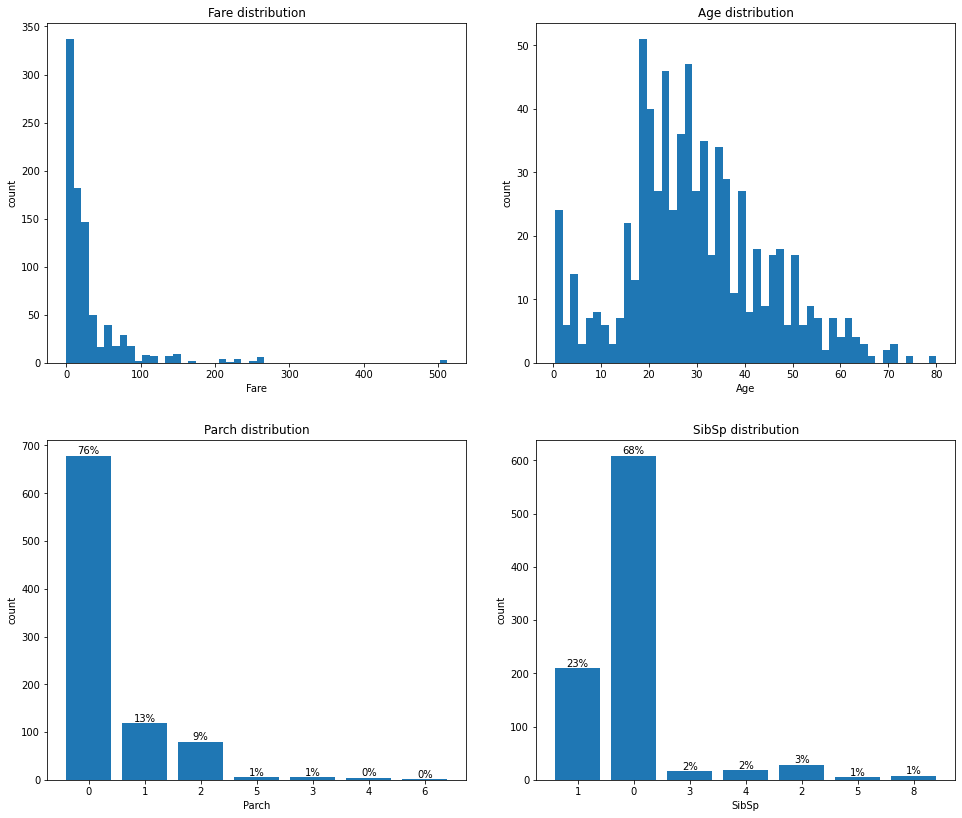

In [12]:
plt.figure(figsize=(14,12))
i=1
for col in num_cols:
  plt.subplot(2,2,i)
  plt.hist(df_train[col], bins=50)
  plt.ylabel('count')
  plt.xlabel(col)
  plt.title(col+' distribution')  
  i+=1

for col in num_cnt_cols:
  plt.subplot(2,2,i)
  vc = df_train[col].value_counts(sort=False)

  plt.bar(vc.index.astype(str), vc)
  plt.ylabel('count')
  plt.xlabel(col)
  plt.title(col+' distribution')

  for id in vc.index:
    plt.annotate("{0:.0f}%".format(vc[id]*100/len(df_train)),xy=(str(id), vc[id]) ,ha='center', va='bottom')

  i+=1

plt.tight_layout(pad=3)
plt.show()


In [13]:
df_train[num_cols + num_cnt_cols].describe()

,Fare,Age,Parch,SibSp
count,891.00,714.00,891.00,891.00
mean,32.20,29.70,0.38,0.52
std,49.69,14.53,0.81,1.10
min,0.00,0.42,0.00,0.00
25%,7.91,20.12,0.00,0.00
50%,14.45,28.00,0.00,0.00
75%,31.00,38.00,0.00,1.00
max,512.33,80.00,6.00,8.00


**Parch & SibSp**
> Most of passengers have 0 PARentsCHildren and 0 SIBlingSPouse => Alone

**Age**
>Most passengers are in 15-35 age range. The average Age is around 30 years.

#### Numerical features distribution / Target

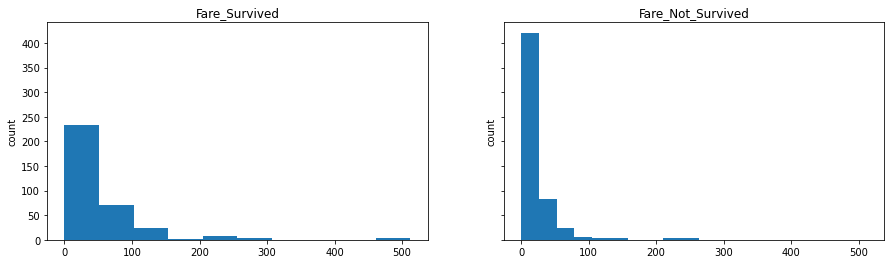

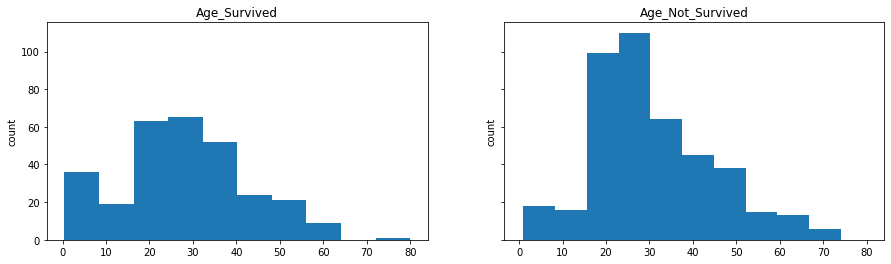

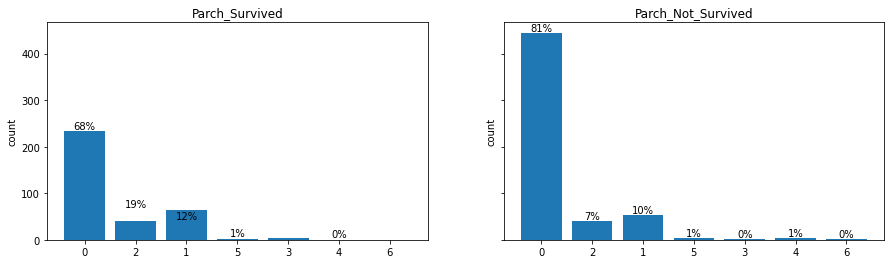

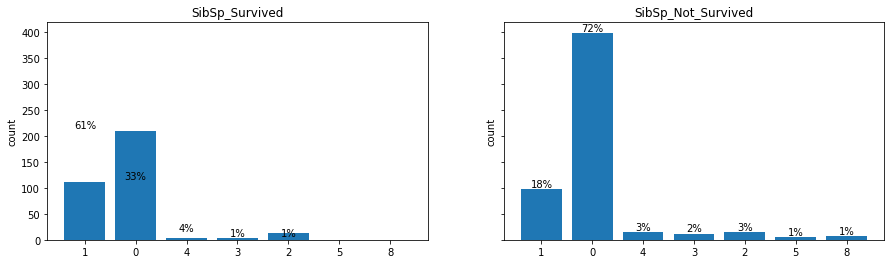

In [14]:
for col in num_cols:
  i=0
  f, sub = plt.subplots(1,2,figsize=(15,4) ,sharex=True, sharey=True)
  sub[i].hist(df_train[col].loc[df_train['Survived']==1])
  sub[i].set_ylabel('count')
  sub[i].set_title(col+'_Survived')
  i+=1
  sub[i].hist(df_train[col].loc[df_train['Survived']==0])
  sub[i].set_ylabel('count')
  sub[i].set_title(col+'_Not_Survived')
  i+=1


for col in num_cnt_cols:
  i=0
  f, sub = plt.subplots(1,2,figsize=(15,4) , sharex=True, sharey=True)
  vc = df_train[col].loc[df_train['Survived']==1].value_counts(sort=False)
  sub[i].bar(vc.index.astype(str),vc)
  sub[i].set_ylabel('count')
  sub[i].set_title(col+'_Survived')

  for id in vc.index:
    sub[i].annotate("{0:.0f}%".format(vc[id]*100/sum(vc)),xy=(id, vc[id]) ,ha='center', va='bottom')

  i+=1

  vc = df_train[col].loc[df_train['Survived']==0].value_counts(sort=False)
  sub[i].bar(vc.index.astype(str),vc)  
  sub[i].set_ylabel('count')
  sub[i].set_title(col+'_Not_Survived')

  for id in vc.index:
    sub[i].annotate("{0:.0f}%".format(vc[id]*100/sum(vc)),xy=(str(id), vc[id]) ,ha='center', va='bottom')

  i+=1

plt.show()


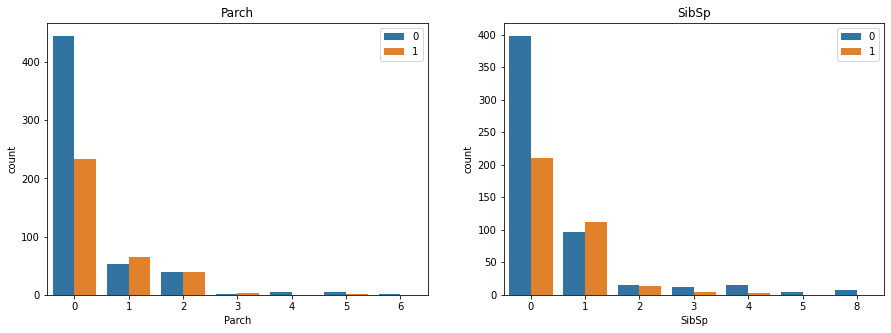

In [15]:
f,sub=plt.subplots(1,2,figsize=(15, 5))
i=0

for col in num_cnt_cols:
  sns.countplot(ax=sub[i], x= col, data = df_train, hue = 'Survived')
  sub[i].legend(loc='upper right')
  sub[i].set_title(col)
  i+=1

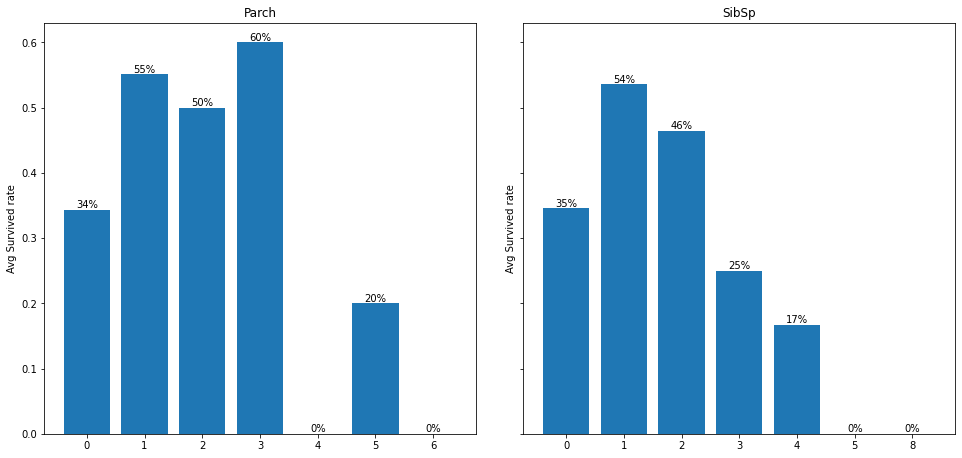

In [16]:
f,sub = plt.subplots(1,2, figsize=(14,7) ,sharey=True)
i=0
for col in num_cnt_cols:
  gp = df_train.groupby([col]).Survived.mean()
  sub[i].bar(gp.index.astype(str), gp)
  sub[i].set_ylabel('Avg Survived rate')
  sub[i].set_title(col)
  for id in gp.index:
    sub[i].annotate("{0:.0f}%".format(gp[id]*100),xy=(str(id), gp[id]) 
    ,ha='center', va='bottom')

  i+=1

plt.tight_layout(pad=3)
plt.show()

**Observations:**

- Lowcost passengers, Alone passenger and big famillies have the worst survival rate we will go further below using Pclass variable

- Children, old (>70) passengers  and small famillies have higher survival rate





#### Nominal features distribution

In [17]:
df_train[nominal_cols].describe(include='O')

,Name,Ticket,Embarked,Sex
count,891,891,891,891
unique,891,681,3,2
top,"Braund, Mr. Owen Harris",347082,S,male
freq,1,7,646,577


We have too many unique values to plot the distribution of **Name** and **Ticket**

In [18]:
# overview of 'Name','Ticket'
df_train[['Name','Ticket']].head()

,Name,Ticket
0,"Braund, Mr. Owen Harris",A/5 21171
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599
2,"Heikkinen, Miss. Laina",STON/O2. 3101282
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803
4,"Allen, Mr. William Henry",373450


From the name we can extract the title

**Distribution of Embarked and Sex**

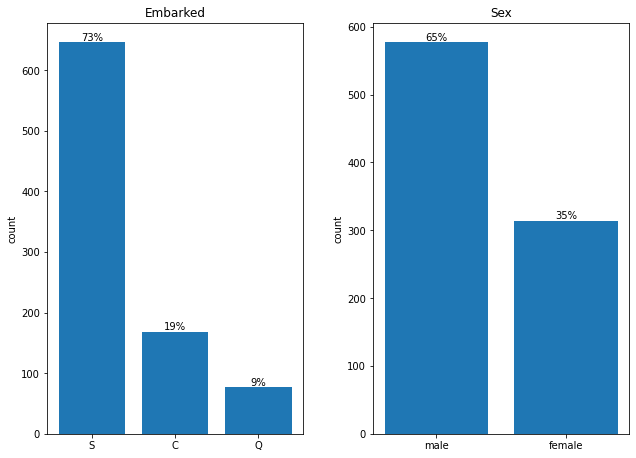

In [19]:
t = df_train[nominal_cols].nunique()<10

plt.figure(figsize=(14,7))
i=1
for col in t[t].index:
  plt.subplot(1,3,i)
  vc = df_train[col].value_counts(sort=False)

  plt.bar(vc.index, vc)
  plt.ylabel('count')
  plt.title(col)

  for id in vc.index:
    plt.annotate("{0:.0f}%".format(vc[id]*100/len(df_train)),xy=(id, vc[id]) ,ha='center', va='bottom')
  
  i+=1
plt.tight_layout(pad=3)
plt.show()

#### Nominal features distribution / Target

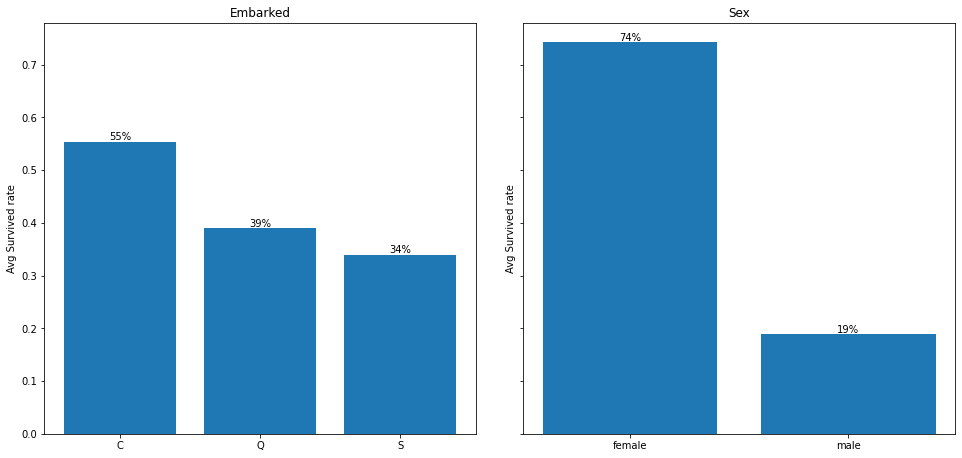

In [20]:
f, sub = plt.subplots(1,2, figsize=(14,7), sharey = True)
i=0
for col in t[t].index:
  gp = df_train.groupby([col]).Survived.mean()
  sub[i].bar(gp.index, gp)
  sub[i].set_ylabel('Avg Survived rate')
  sub[i].set_title(col)
  for id in gp.index:
    sub[i].annotate("{0:.0f}%".format(gp[id]*100),xy=(id, gp[id]) 
    ,ha='center', va='bottom')
  i+=1
plt.tight_layout(pad=3)
plt.show()


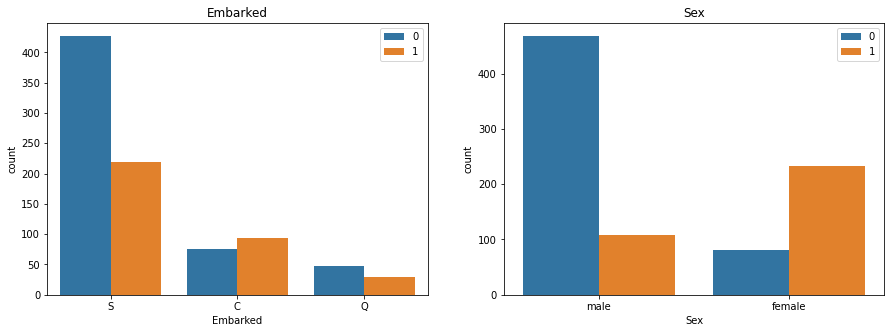

In [21]:
f,sub=plt.subplots(1,2,figsize=(15, 5))
i=0

for col in t[t].index:
  sns.countplot(ax=sub[i], x= col, data = df_train, hue = 'Survived')
  sub[i].legend(loc='upper right')
  sub[i].set_title(col)
  i+=1

Observations:

- Male passengers have a terrible survival rate (80% died) and female a great one (74% survived)
- Passengers have embarked from C have higher survival rate (55%) much better than passengers from S (34%) it may be related to the class



#### Ordinal features distribution

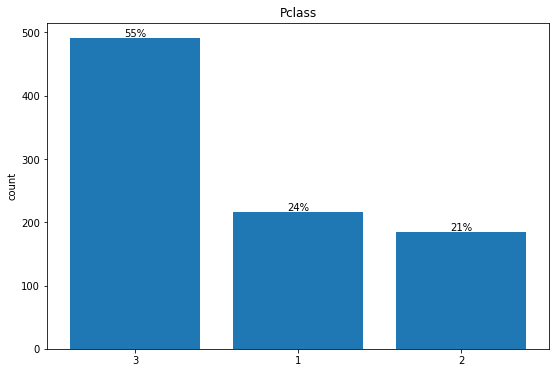

In [22]:
t = df_train['Pclass'].value_counts(sort=False)

plt.figure(figsize=(9,6))
plt.bar(t.index.astype('str'), t.values)
plt.ylabel('count')
plt.title('Pclass')

for id in t.index:
  plt.annotate("{0:.0f}%".format(t[id]*100/sum(t)),xy=(str(id), t[id]) ,ha='center', va='bottom')
plt.show()

#### Ordinal features distribution / target

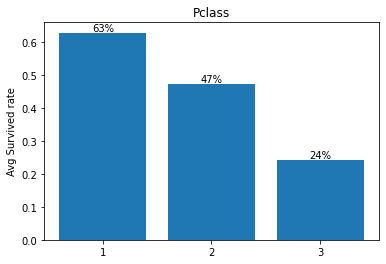

In [23]:
col='Pclass'
gp = df_train.groupby([col]).Survived.mean()
plt.bar(gp.index.astype(str), gp)
plt.ylabel('Avg Survived rate')
plt.title(col)
for id in gp.index:
  plt.annotate("{0:.0f}%".format(gp[id]*100),xy=(str(id), gp[id]) 
  ,ha='center', va='bottom')
plt.show()

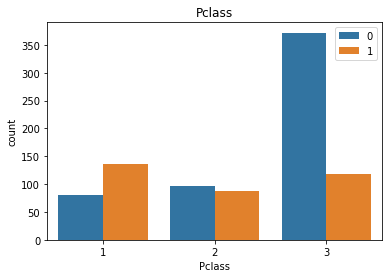

In [24]:
sns.countplot(x= col, data = df_train, hue = 'Survived')
plt.legend(loc='upper right')
plt.title(col)
plt.show()

Observations:

- Better the Pclass is, greater is the survival rate. It comfirms our observation below on lowcost passenger

# Feature engineering 


Title / Familly / Alone / Connected Survival


#### Title

In [25]:
for df in dfs:
  df[1]['Title'] = df[1]['Name'].str.extract('([A-Za-z]+)\.', expand=False)
  print(df[0],':')
  display(pd.crosstab(df[1]['Title'], df[1]['Sex']))
  print('\n\n')

train :


Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40





test :


Sex,female,male
Title,,
Col,0,2
Dona,1,0
Dr,0,1
Master,0,21
Miss,78,0
Mr,0,240
Mrs,72,0
Ms,1,0
Rev,0,2


In [26]:
for df in dfs:
  df[1]['Title'] = df[1]['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
  'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'High')
  df[1]['Title'] = df[1]['Title'].replace('Mlle', 'Miss')
  df[1]['Title'] = df[1]['Title'].replace('Ms', 'Miss')
  df[1]['Title'] = df[1]['Title'].replace('Mme', 'Mrs')

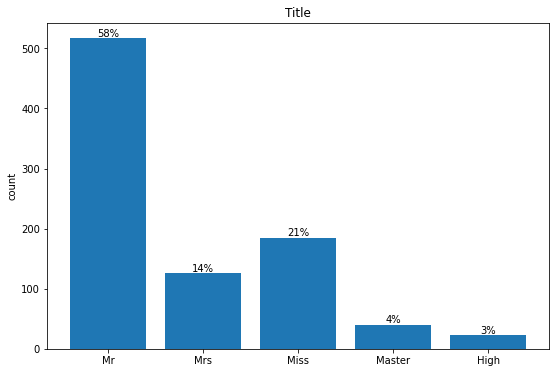

In [27]:
t = df_train['Title'].value_counts(sort=False)

plt.figure(figsize=(9,6))
plt.bar(t.index.astype('str'), t.values)
plt.ylabel('count')
plt.title('Title')

for id in t.index:
  plt.annotate("{0:.0f}%".format(t[id]*100/sum(t)),xy=(str(id), t[id]) ,ha='center', va='bottom')
plt.show()

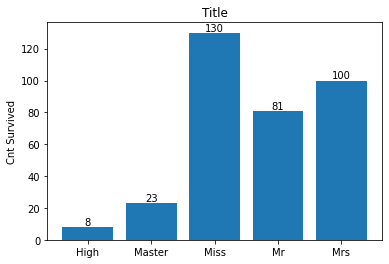

In [28]:
gp = df_train.groupby(['Title']).Survived.sum()
plt.bar(gp.index, gp)
plt.ylabel('Cnt Survived')
plt.title('Title')

for id in gp.index:
  plt.annotate("{0:.0f}".format(gp[id]),xy=(id, gp[id]) 
  ,ha='center', va='bottom')

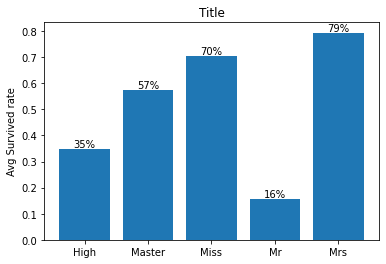

In [29]:
gp = df_train.groupby(['Title']).Survived.mean()
plt.bar(gp.index, gp)
plt.ylabel('Avg Survived rate')
plt.title('Title')

for id in gp.index:
  plt.annotate("{0:.0f}%".format(gp[id]*100),xy=(id, gp[id]) 
  ,ha='center', va='bottom')

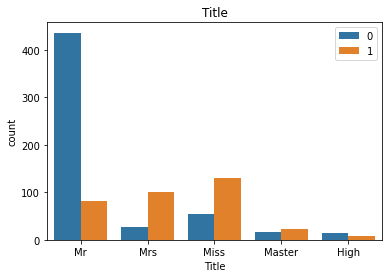

In [30]:
col='Title'
sns.countplot(x= col, data = df_train, hue = 'Survived')
plt.legend(loc='upper right')
plt.title(col)
plt.show()

In [31]:
nominal_cols.append('Title')

**Observations:**

- Validating our previous observation female (Mrs, Miss) have much higher survival rate than male (Mr).

- Hight & Master title have higher survival rate than Mr and a lower than female (Mrs, Miss)

#### Familly

From [link](https://www.encyclopedia-titanica.org/titanic-victim/charles-natsch.html) there is an error this passenger traveled alone


In [32]:
# error this passenger traveled alone
df_train.loc[273, 'Parch'] = 0

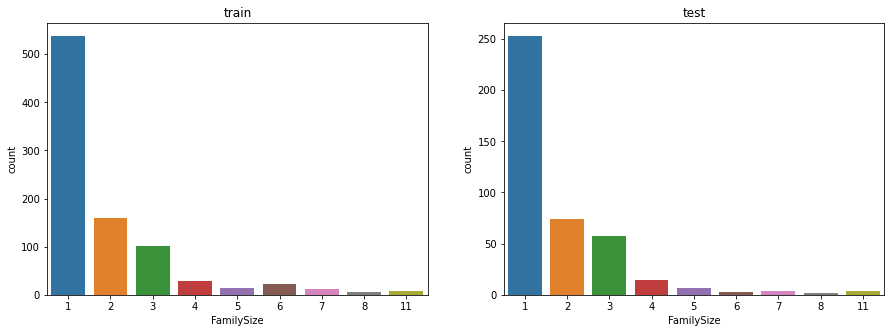

In [33]:
f,sub=plt.subplots(1,2,figsize=(15, 5))
i=0

for df in dfs:
  df[1]['FamilySize'] = df[1]['SibSp'] + df[1]['Parch'] +1
  sns.countplot(ax=sub[i], x= 'FamilySize',data =df[1])
  sub[i].set_title(df[0])
  i+=1


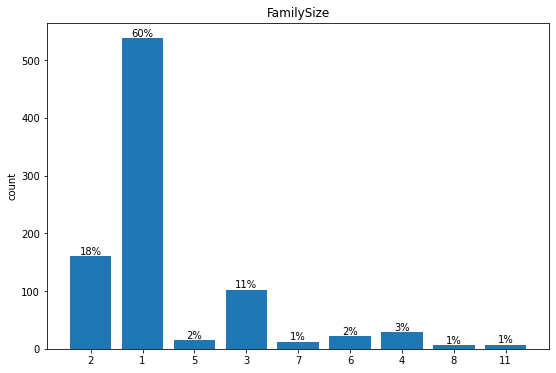

In [34]:
t = df_train['FamilySize'].value_counts(sort=False)

plt.figure(figsize=(9,6))
plt.bar(t.index.astype('str'), t.values)
plt.ylabel('count')
plt.title('FamilySize')

for id in t.index:
  plt.annotate("{0:.0f}%".format(t[id]*100/sum(t)),xy=(str(id), t[id]) ,ha='center', va='bottom')
plt.show()

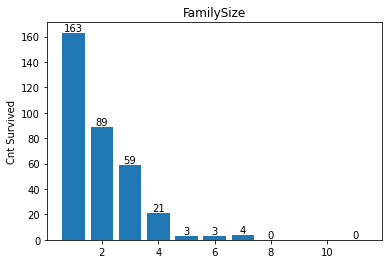

In [35]:
gp = df_train.groupby(['FamilySize']).Survived.sum()
plt.bar(gp.index, gp)
plt.ylabel('Cnt Survived')
plt.title('FamilySize')

for id in gp.index:
  plt.annotate("{0:.0f}".format(gp[id]),xy=(id, gp[id]) 
  ,ha='center', va='bottom')

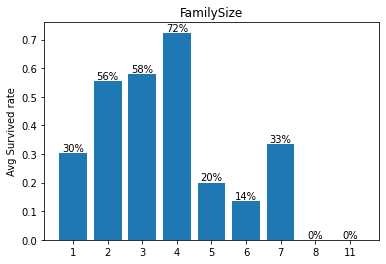

In [36]:
gp = df_train.groupby(['FamilySize']).Survived.mean()
plt.bar(gp.index.astype('str'), gp)
plt.ylabel('Avg Survived rate')
plt.title('FamilySize')

for id in gp.index:
  plt.annotate("{0:.0f}%".format(gp[id]*100),xy=(str(id), gp[id]) 
  ,ha='center', va='bottom')

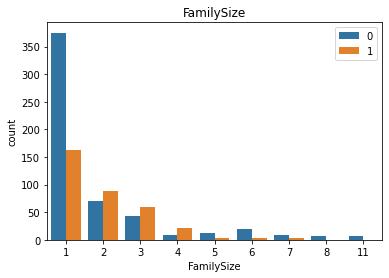

In [37]:
col='FamilySize'
sns.countplot(x= col, data = df_train, hue = 'Survived')
plt.legend(loc='upper right')
plt.title(col)
plt.show()

Observations:

- The survival rate increase with the familly size until 4 and decrease after

#### Alone

train :


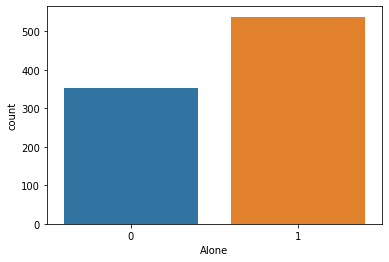




test :


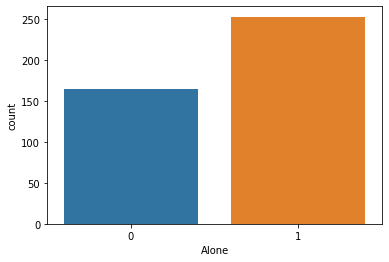

In [38]:
for df in dfs:
  df[1]['Alone'] = 0
  df[1].loc[df[1]['FamilySize']==1, 'Alone' ] = 1
  print(df[0],':')
  sns.countplot(df[1]['Alone'])
  plt.show()
  print('\n\n')

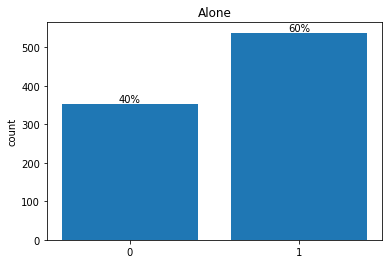

In [39]:
t = df_train['Alone'].value_counts(sort=False)

plt.figure(figsize=(6,4))
plt.bar(t.index.astype('str'), t.values)
plt.ylabel('count')
plt.title('Alone')

for id in t.index:
  plt.annotate("{0:.0f}%".format(t[id]*100/sum(t)),xy=(str(id), t[id]) ,ha='center', va='bottom')
plt.show()

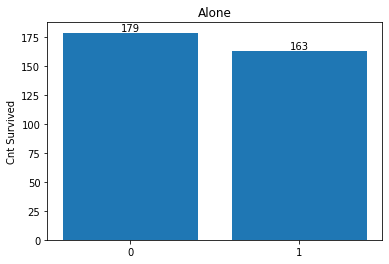

In [40]:
gp = df_train.groupby(['Alone']).Survived.sum()
plt.bar(gp.index.astype('str'), gp)
plt.ylabel('Cnt Survived')
plt.title('Alone')

for id in gp.index:
  plt.annotate("{0:.0f}".format(gp[id]),xy=(str(id), gp[id]) 
  ,ha='center', va='bottom')

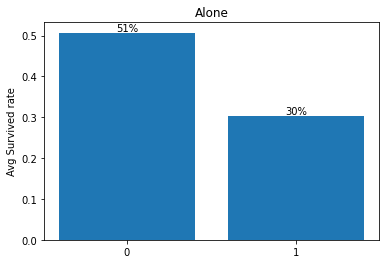

In [41]:
gp = df_train.groupby(['Alone']).Survived.mean()
plt.bar(gp.index.astype('str'), gp)
plt.ylabel('Avg Survived rate')
plt.title('Alone')

for id in gp.index:
  plt.annotate("{0:.0f}%".format(gp[id]*100),xy=(str(id), gp[id]) 
  ,ha='center', va='bottom')

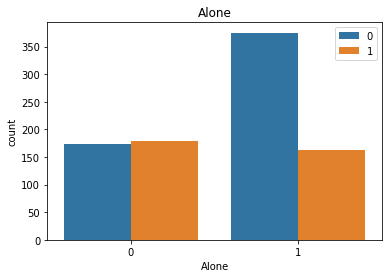

In [42]:
col='Alone'
sns.countplot(x= col, data = df_train, hue = 'Survived')
plt.legend(loc='upper right')
plt.title(col)
plt.show()

Observations:

- The survival rate is lower for alone passenger

#### Last Name

In [43]:
for df in dfs:
  df[1]['Last_Name'] = df[1]['Name'].apply(lambda x: str.split(x, ",")[0])

In [44]:
df_train.sort_values('Name').head(10)

,PassengerId,Survived,Pclass,Name,Sex,...,Embarked,Title,FamilySize,Alone,Last_Name
845,846,0,3,"Abbing, Mr. Anthony",male,...,S,Mr,1,1,Abbing
746,747,0,3,"Abbott, Mr. Rossmore Edward",male,...,S,Mr,3,0,Abbott
279,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,...,S,Mrs,3,0,Abbott
308,309,0,2,"Abelson, Mr. Samuel",male,...,C,Mr,2,0,Abelson
874,875,1,2,"Abelson, Mrs. Samuel (Hannah Wizosky)",female,...,C,Mrs,2,0,Abelson
365,366,0,3,"Adahl, Mr. Mauritz Nils Martin",male,...,S,Mr,1,1,Adahl
401,402,0,3,"Adams, Mr. John",male,...,S,Mr,1,1,Adams
40,41,0,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,...,S,Mrs,2,0,Ahlin
855,856,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,...,S,Mrs,2,0,Aks
207,208,1,3,"Albimona, Mr. Nassef Cassem",male,...,C,Mr,1,1,Albimona


#### Familly id


We will try to group famillies


In [45]:
df_test['Survived'] = 9

In [46]:
df_full = pd.concat([df_train, df_test], axis = 0).sort_values('Name').reset_index(drop=True)
df_full.head()

,PassengerId,Survived,Pclass,Name,Sex,...,Embarked,Title,FamilySize,Alone,Last_Name
0,846,0,3,"Abbing, Mr. Anthony",male,...,S,Mr,1,1,Abbing
1,1284,9,3,"Abbott, Master. Eugene Joseph",male,...,S,Master,3,0,Abbott
2,747,0,3,"Abbott, Mr. Rossmore Edward",male,...,S,Mr,3,0,Abbott
3,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,...,S,Mrs,3,0,Abbott
4,1237,9,3,"Abelseth, Miss. Karen Marie",female,...,S,Miss,1,1,Abelseth


##### Group by ticket / Familly size

People with the same ticket and the same family size are supposed to be in the same family

In [47]:
df_sub_full = df_full[['PassengerId', 'FamilySize', 'Alone', 'Ticket']]
gb_Tick_FamSize = df_sub_full.loc[df_sub_full['Alone'] == 0].groupby(['Ticket','FamilySize']).count()
gb_Tick_FamSize.head()

,,PassengerId,Alone
Ticket,FamilySize,,
110413,3,3,3
110813,2,2,2
111361,2,2,2
112378,2,2,2
112901,3,1,1


In [48]:
gb_Tick_FamSize.reset_index(inplace=True)
gb_Tick_FamSize.drop(['Alone'], axis =1, inplace=True )
gb_Tick_FamSize.rename(columns={'PassengerId':'CntPassengerId'}, inplace=True)
gb_Tick_FamSize = pd.DataFrame(gb_Tick_FamSize)

In [49]:
# Families where the group by count = Family size
fam_id_table = gb_Tick_FamSize.loc[gb_Tick_FamSize['FamilySize'] == gb_Tick_FamSize['CntPassengerId']]
fam_id_table['Familly_id'] = np.arange(1,len(fam_id_table)+1)
fam_id_table.head()

,Ticket,FamilySize,CntPassengerId,Familly_id
0,110413,3,3,1
1,110813,2,2,2
2,111361,2,2,3
3,112378,2,2,4
5,113503,3,3,5


**We will join the 2 tables**

In [50]:
df_full = df_full.merge(fam_id_table, how='left' ,on=['Ticket', 'FamilySize'])
df_full.drop('CntPassengerId', axis=1, inplace=True)
df_full.head()

,PassengerId,Survived,Pclass,Name,Sex,...,Title,FamilySize,Alone,Last_Name,Familly_id
0,846,0,3,"Abbing, Mr. Anthony",male,...,Mr,1,1,Abbing,NaN
1,1284,9,3,"Abbott, Master. Eugene Joseph",male,...,Master,3,0,Abbott,114.00
2,747,0,3,"Abbott, Mr. Rossmore Edward",male,...,Mr,3,0,Abbott,114.00
3,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,...,Mrs,3,0,Abbott,114.00
4,1237,9,3,"Abelseth, Miss. Karen Marie",female,...,Miss,1,1,Abelseth,NaN


##### Group by Last_Name / Familly size / Pclass

People with the same last name, familly size and Pclass are supposed to be in the same family

In [51]:
df_sub_full = df_full[['PassengerId', 'FamilySize', 'Alone','Last_Name','Pclass' ,'Familly_id']]
gb_LastName_FamSize_PCl = df_sub_full.loc[(df_sub_full['Alone'] == 0) & (df_sub_full['Familly_id'].isnull())].groupby(['Last_Name', 'FamilySize', 'Pclass']).count()
gb_LastName_FamSize_PCl.reset_index(inplace=True)
gb_LastName_FamSize_PCl.drop(['Alone', 'Familly_id'], axis =1, inplace=True)
gb_LastName_FamSize_PCl.rename(columns={'PassengerId':'CntPassengerId'}, inplace=True)

In [52]:
# Families where the group by count = Family size
fam_id_table_2 = gb_LastName_FamSize_PCl.loc[gb_LastName_FamSize_PCl['FamilySize'] == gb_LastName_FamSize_PCl['CntPassengerId']]
fam_id_table_2['Familly_id'] = np.arange(len(fam_id_table)+1, len(fam_id_table)+ len(fam_id_table_2)+1)
fam_id_table_2.head()

,Last_Name,FamilySize,Pclass,CntPassengerId,Familly_id
7,Bourke,3,3,3,153
8,Braund,2,3,2,154
12,Crosby,3,1,3,155
15,Davies,3,3,3,156
17,Duff Gordon,2,1,2,157


In [53]:
df_full = df_full.merge(fam_id_table_2, how='left' ,on=['Last_Name', 'FamilySize', 'Pclass'])
df_full.drop('CntPassengerId', axis=1, inplace=True)
df_full.head()

,PassengerId,Survived,Pclass,Name,Sex,...,FamilySize,Alone,Last_Name,Familly_id_x,Familly_id_y
0,846,0,3,"Abbing, Mr. Anthony",male,...,1,1,Abbing,NaN,NaN
1,1284,9,3,"Abbott, Master. Eugene Joseph",male,...,3,0,Abbott,114.00,NaN
2,747,0,3,"Abbott, Mr. Rossmore Edward",male,...,3,0,Abbott,114.00,NaN
3,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,...,3,0,Abbott,114.00,NaN
4,1237,9,3,"Abelseth, Miss. Karen Marie",female,...,1,1,Abelseth,NaN,NaN


In [54]:
df_full.loc[(df_full.Familly_id_y.notnull()) | (df_full.Familly_id_x.notnull())].head()

,PassengerId,Survived,Pclass,Name,Sex,...,FamilySize,Alone,Last_Name,Familly_id_x,Familly_id_y
1,1284,9,3,"Abbott, Master. Eugene Joseph",male,...,3,0,Abbott,114.00,NaN
2,747,0,3,"Abbott, Mr. Rossmore Edward",male,...,3,0,Abbott,114.00,NaN
3,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,...,3,0,Abbott,114.00,NaN
6,309,0,2,"Abelson, Mr. Samuel",male,...,2,0,Abelson,122.00,NaN
7,875,1,2,"Abelson, Mrs. Samuel (Hannah Wizosky)",female,...,2,0,Abelson,122.00,NaN


In [55]:
df_full.loc[(df_full.Alone == 0)].head()

,PassengerId,Survived,Pclass,Name,Sex,...,FamilySize,Alone,Last_Name,Familly_id_x,Familly_id_y
1,1284,9,3,"Abbott, Master. Eugene Joseph",male,...,3,0,Abbott,114.00,NaN
2,747,0,3,"Abbott, Mr. Rossmore Edward",male,...,3,0,Abbott,114.00,NaN
3,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,...,3,0,Abbott,114.00,NaN
6,309,0,2,"Abelson, Mr. Samuel",male,...,2,0,Abelson,122.00,NaN
7,875,1,2,"Abelson, Mrs. Samuel (Hannah Wizosky)",female,...,2,0,Abelson,122.00,NaN


In [56]:
sub = df_full.loc[(df_full.Alone == 0)]
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
sub.loc[(sub.Familly_id_y.isnull()) & (sub.Familly_id_x.isnull())].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,FamilySize,Alone,Last_Name,Familly_id_x,Familly_id_y
12,41,0,3,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40.00,1,0,7546,9.47,S,Mrs,2,0,Ahlin,NaN,NaN
29,193,1,3,"Andersen-Jensen, Miss. Carla Christine Nielsine",female,19.00,1,0,350046,7.85,S,Miss,2,0,Andersen-Jensen,NaN,NaN
34,69,1,3,"Andersson, Miss. Erna Alexandra",female,17.00,4,2,3101281,7.92,S,Miss,7,0,Andersson,NaN,NaN
35,1106,9,3,"Andersson, Miss. Ida Augusta Margareta",female,38.00,4,2,347091,7.78,S,Miss,7,0,Andersson,NaN,NaN
50,572,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.00,2,0,11769,51.48,S,Mrs,3,0,Appleton,NaN,NaN


There is 65 people without familly_id

For this 65 people I will do manual search on internet (https://www.encyclopedia-titanica.org/)

##### MANUAL SEARCH

In [57]:
cnt_fam_id = len(fam_id_table)+ len(fam_id_table_2)
cnt_fam_id

171

In [58]:
df_full.loc[ (df_full['Last_Name'] == 'Ahlin') | (df_full['Last_Name'] == 'Petterson'), 'Familly_id_z' ] = cnt_fam_id
cnt_fam_id += 1

In [59]:
sub = df_full.loc[ (df_full['Last_Name'] == 'Andersen-Jensen') | (df_full['Last_Name'] == 'Jensen')]
idx = sub.loc[sub['Alone']!= 1].index
df_full.loc[idx, 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

In [60]:
sub = df_full.loc[ (df_full['Last_Name'] == 'Andersson') | (df_full['Last_Name'] == 'Backstrom') | (df_full['Last_Name'] == 'Gustafsson')]
sub = sub.loc[sub['Alone']!= 1]
idx = sub.loc[(sub.Familly_id_y.isnull()) & (sub.Familly_id_x.isnull()) & (sub.Familly_id_z.isnull())].index
df_full.loc[idx, 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

In [61]:
sub = df_full.loc[(df_full['Last_Name'] == 'Appleton') | (df_full['Last_Name'] == 'Brown')  | (df_full['Last_Name'] == 'Cornell') ] 
sub = sub.loc[sub['Alone']!= 1]
idx = sub.loc[(sub.Familly_id_y.isnull()) & (sub.Familly_id_x.isnull()) & (sub.Familly_id_z.isnull())].index
df_full.loc[idx, 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

In [62]:
df_full.loc[ (df_full['Last_Name'] == 'Beckwith') | (df_full['Last_Name'] == 'Newsom'), 'Familly_id_z' ] = cnt_fam_id
cnt_fam_id += 1

In [63]:
df_full.loc[ (df_full['Last_Name'] == 'Christy') | (df_full['Last_Name'] == 'Jacobsohn'), 'Familly_id_z' ] = cnt_fam_id
cnt_fam_id += 1

In [64]:
sub = df_full.loc[ (df_full['Last_Name'] == 'Davidson') | (df_full['Last_Name'] == 'Hays')]
sub = sub.loc[sub['Alone']!= 1]
idx = sub.loc[(sub.Familly_id_y.isnull()) & (sub.Familly_id_x.isnull()) & (sub.Familly_id_z.isnull())].index
df_full.loc[idx, 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

In [65]:
df_full.loc[ (df_full['Ticket'] == 'PC 17558') & (df_full['Alone'] == 0) & (df_full['Familly_id_x'].isnull()), 'Familly_id_x'] =124

In [66]:
df_full.loc[ (df_full['Last_Name'] == 'Frauenthal') & (df_full['Alone'] == 0) & (df_full['Familly_id_y'].isnull()), 'Familly_id_y'] = 160

In [67]:
df_full.loc[ (df_full['Last_Name'] == 'Frolicher-Stehli') | (df_full['Last_Name'] == 'Frolicher'), 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

In [68]:
df_full.loc[ (df_full['Last_Name'] == 'Hiltunen') |  (df_full['Last_Name'] == 'Hamalainen'), 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

In [69]:
df_full.loc[ (df_full['Last_Name'] == 'Hansen')& (df_full['Alone'] == 0), 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

In [70]:
df_full.loc[ (df_full['Last_Name'] == 'Hirvonen') | (df_full['Last_Name'] == 'Lindqvist'), 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

In [71]:
sub = df_full.loc[ (df_full['Last_Name'] == 'Hocking') | (df_full['Last_Name'] == 'Richards')| (df_full['Last_Name'] == 'Wilkes') ]
idx = sub.loc[sub['Alone']==0].index
idx = sub.loc[(sub.Familly_id_y.isnull()) & (sub.Familly_id_x.isnull()) & (sub.Familly_id_z.isnull())].index
df_full.loc[idx, 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

In [72]:
df_full.loc[ (df_full['Last_Name'] == 'Jefferys') | (df_full['Last_Name'] == 'Renouf'), 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

In [73]:
df_full.loc[ (df_full['Last_Name'] == 'Kink') | (df_full['Last_Name'] == 'Kink-Heilmann'), 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

In [74]:
df_full.loc[ (df_full['Last_Name'] == 'Lahtinen') | (df_full['Last_Name'] == 'Silven') , 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

In [75]:
df_full.loc[ (df_full['Last_Name'] == 'Minahan'), 'Familly_id_x'] = 32


In [76]:
df_full.loc[ (df_full['Last_Name'] == 'Newell'), 'Familly_id_x'] = 90

In [77]:
sub = df_full.loc[ (df_full['Last_Name'] == 'Persson') | (df_full['Last_Name'] == 'Strom') ]
idx = sub.loc[sub['Alone']==0].index
idx = sub.loc[(sub.Familly_id_y.isnull()) & (sub.Familly_id_x.isnull()) & (sub.Familly_id_z.isnull())].index
df_full.loc[idx, 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

In [78]:
df_full.loc[ (df_full['Last_Name'] == 'Thomas')& (df_full['Alone'] == 0), 'Familly_id_y'] = 169

In [79]:
df_full.loc[ (df_full['Last_Name'] == 'Vander Planke')& (df_full['Alone'] == 0) , 'Familly_id_z'] = cnt_fam_id 
cnt_fam_id += 1

##### VERIF

In [80]:
sub = df_full.loc[(df_full.Alone == 0)]
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
sub.loc[(sub.Familly_id_y.isnull()) & (sub.Familly_id_x.isnull()) & (sub.Familly_id_z.isnull())]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,FamilySize,Alone,Last_Name,Familly_id_x,Familly_id_y,Familly_id_z


In [81]:
len(sub.loc[(sub.Familly_id_y.isnull()) & (sub.Familly_id_x.isnull()) & (sub.Familly_id_z.isnull())])

0

In [82]:
df_full.loc[ (df_full['Last_Name'] == 'Natsch')& (df_full['Alone'] == 0)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,FamilySize,Alone,Last_Name,Familly_id_x,Familly_id_y,Familly_id_z


##### OUT

In [83]:
df_full['Familly_id'] = df_full[['Familly_id_x','Familly_id_y','Familly_id_z']].fillna(0).apply(sum, axis=1)

In [84]:
df_full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,FamilySize,Alone,Last_Name,Familly_id_x,Familly_id_y,Familly_id_z,Familly_id
0,846,0,3,"Abbing, Mr. Anthony",male,42.00,0,0,C.A. 5547,7.55,S,Mr,1,1,Abbing,NaN,NaN,NaN,0.00
1,1284,9,3,"Abbott, Master. Eugene Joseph",male,13.00,0,2,C.A. 2673,20.25,S,Master,3,0,Abbott,114.00,NaN,NaN,114.00
2,747,0,3,"Abbott, Mr. Rossmore Edward",male,16.00,1,1,C.A. 2673,20.25,S,Mr,3,0,Abbott,114.00,NaN,NaN,114.00
3,280,1,3,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.00,1,1,C.A. 2673,20.25,S,Mrs,3,0,Abbott,114.00,NaN,NaN,114.00
4,1237,9,3,"Abelseth, Miss. Karen Marie",female,16.00,0,0,348125,7.65,S,Miss,1,1,Abelseth,NaN,NaN,NaN,0.00


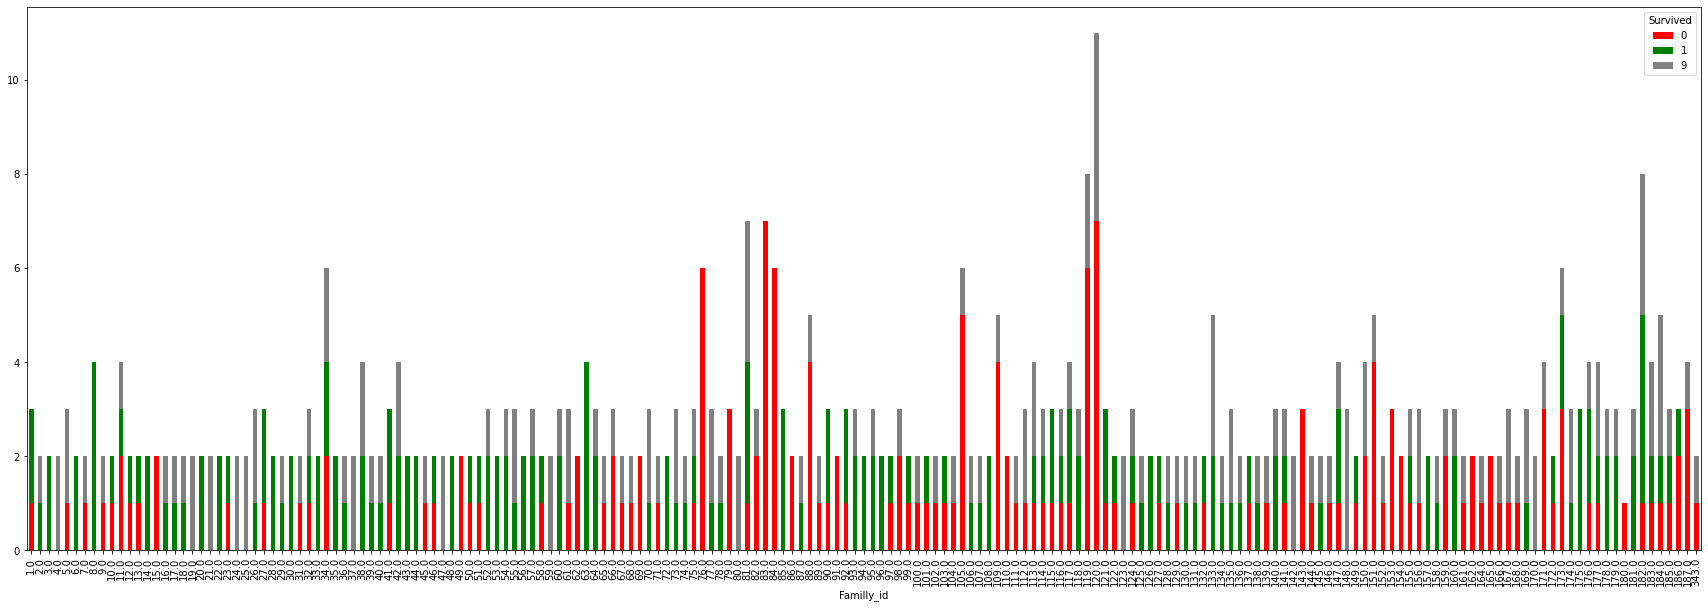

In [85]:
pd.crosstab(df_full['Familly_id'], df_full['Survived']).drop([0]).plot(kind='bar', stacked=True, color=['r','g','grey'], figsize=(30,10))
plt.show()

We can see that famillies are a group they all die or all survived exception for couple

#### Couple

In [86]:
df_full.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,FamilySize,Alone,Last_Name,Familly_id_x,Familly_id_y,Familly_id_z,Familly_id
0,846,0,3,"Abbing, Mr. Anthony",male,42.00,0,0,C.A. 5547,7.55,S,Mr,1,1,Abbing,NaN,NaN,NaN,0.00
1,1284,9,3,"Abbott, Master. Eugene Joseph",male,13.00,0,2,C.A. 2673,20.25,S,Master,3,0,Abbott,114.00,NaN,NaN,114.00


In [87]:
df_full['group_size'] = df_full.groupby(['Familly_id']).PassengerId.transform('count')
df_full.loc[df_full['group_size']==790, 'group_size'] = 0

In [88]:
d_sex = {'male':1, 'female' : 0}
df_full['Sex'] = df_full['Sex'].map(d_sex)
# df_full.loc[df_full['group_size']==2].groupby(['Familly_id']).Sex.sum()

In [89]:
df_full['grp_cnt_male'] = df_full.groupby(['Familly_id']).Sex.transform('sum')

In [90]:
df_full.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,FamilySize,Alone,Last_Name,Familly_id_x,Familly_id_y,Familly_id_z,Familly_id,group_size,grp_cnt_male
0,846,0,3,"Abbing, Mr. Anthony",1,42.00,0,0,C.A. 5547,7.55,S,Mr,1,1,Abbing,NaN,NaN,NaN,0.00,0,596
1,1284,9,3,"Abbott, Master. Eugene Joseph",1,13.00,0,2,C.A. 2673,20.25,S,Master,3,0,Abbott,114.00,NaN,NaN,114.00,3,2


In [91]:
df_full['Couple'] = 0

In [92]:
df_full.loc[ (df_full['group_size'] == 2) & (df_full['grp_cnt_male'] == 1) & (df_full['SibSp'] == 1), 'Couple'] = 1

In [93]:
couple = df_full.loc[df_full['Couple'] == 1 ]

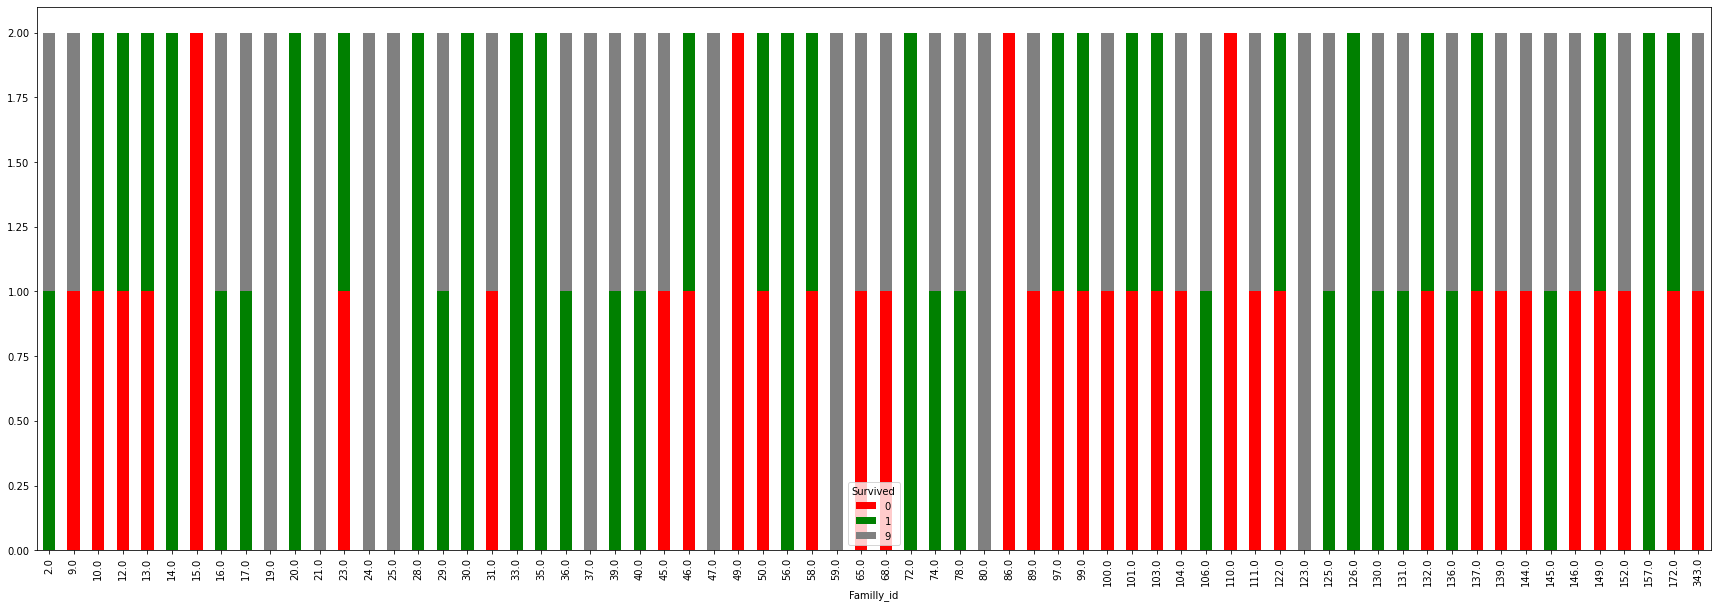

In [94]:
pd.crosstab(couple['Familly_id'], couple['Survived']).plot(kind='bar', stacked=True, color=['r','g','grey'], figsize=(30,10))
plt.show()

### Data correlation

In [95]:
# d_sex = {'male':1, 'female' : 0}
# for df in dfs:
#   df[1]['Sex'] = df[1]['Sex'].map(d_sex)

In [96]:
# mask = np.triu(np.ones_like(df_train.corr(), dtype=bool))

In [97]:
# plt.figure(figsize=(12,6))
# sns.heatmap(df_train.corr(),mask=mask ,annot = True, fmt = '.2f')
# plt.show()

## Fill NAn

#### Fare

We saw there is only one passenger with missing Fare value in test set. 

According to correlation graph, Fare is corralated to family size (Parch and SibSp), Sex and Pclass features. 

Median Fare value of a male with a third class ticket and no family is a logical choice to fill the missing value.

In [98]:
df_full.groupby(['Pclass','Sex' ,'Parch', 'SibSp']).Fare.median()[3][1][0][0]

7.8875

In [99]:
med_fare = df_full.groupby(['Pclass','Sex' ,'Parch', 'SibSp']).Fare.median()[3][1][0][0]
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
df_full.loc[(df_full['Fare'].isnull()) & (df_full['Survived']==9),'Fare'] = med_fare

#### Age


We will use a model to predict missing Age

In [100]:
df_full = df_full.sort_values(by='PassengerId').reset_index(drop=True)
df_full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,FamilySize,Alone,Last_Name,Familly_id_x,Familly_id_y,Familly_id_z,Familly_id,group_size,grp_cnt_male,Couple
0,1,0,3,"Braund, Mr. Owen Harris",1,22.00,1,0,A/5 21171,7.25,S,Mr,2,0,Braund,NaN,154.00,NaN,154.00,2,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.00,1,0,PC 17599,71.28,C,Mrs,2,0,Cumings,130.00,NaN,NaN,130.00,2,1,1
2,3,1,3,"Heikkinen, Miss. Laina",0,26.00,0,0,STON/O2. 3101282,7.92,S,Miss,1,1,Heikkinen,NaN,NaN,NaN,0.00,0,596,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.00,1,0,113803,53.10,S,Mrs,2,0,Futrelle,13.00,NaN,NaN,13.00,2,1,1
4,5,0,3,"Allen, Mr. William Henry",1,35.00,0,0,373450,8.05,S,Mr,1,1,Allen,NaN,NaN,NaN,0.00,0,596,0


In [101]:
df_train_test = df_full.copy()
df_train_test.drop(['Name', 'Last_Name', 'Ticket', 'Familly_id_x', 'Familly_id_y', 'Familly_id_z', 'FamilySize' ,'grp_cnt_male'], axis =1, inplace = True)
df_train_test

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Alone,Familly_id,group_size,Couple
0,1,0,3,1,22.00,1,0,7.25,S,Mr,0,154.00,2,0
1,2,1,1,0,38.00,1,0,71.28,C,Mrs,0,130.00,2,1
2,3,1,3,0,26.00,0,0,7.92,S,Miss,1,0.00,0,0
3,4,1,1,0,35.00,1,0,53.10,S,Mrs,0,13.00,2,1
4,5,0,3,1,35.00,0,0,8.05,S,Mr,1,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,9,3,1,NaN,0,0,8.05,S,Mr,1,0.00,0,0
1305,1306,9,1,0,39.00,0,0,108.90,C,High,1,0.00,0,0
1306,1307,9,3,1,38.50,0,0,7.25,S,Mr,1,0.00,0,0
1307,1308,9,3,1,NaN,0,0,8.05,S,Mr,1,0.00,0,0


### Encoding

Feature to encode: 
- Sex (binary)
- Embarked (OHE)
- Title (OHE)

In [102]:
# Sex
# d_sex = {'male':1, 'female' : 0}
# df_train_test['Sex'] = df_train_test['Sex'].map(d_sex)

In [103]:
# Embarked, Title
df_train_test = pd.get_dummies(df_train_test, columns=['Embarked', 'Title'])
df_train_test.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Alone,Familly_id,group_size,Couple,Embarked_C,Embarked_Q,Embarked_S,Title_High,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,1,0,3,1,22.00,1,0,7.25,0,154.00,2,0,0,0,1,0,0,0,1,0
1,2,1,1,0,38.00,1,0,71.28,0,130.00,2,1,1,0,0,0,0,0,0,1
2,3,1,3,0,26.00,0,0,7.92,1,0.00,0,0,0,0,1,0,0,1,0,0
3,4,1,1,0,35.00,1,0,53.10,0,13.00,2,1,0,0,1,0,0,0,0,1
4,5,0,3,1,35.00,0,0,8.05,1,0.00,0,0,0,0,1,0,0,0,1,0


In [104]:
col_to_add_after_training = ['Survived', 'Familly_id','PassengerId', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
add_columns_train_test = df_train_test[col_to_add_after_training]

In [105]:
# we drop survived bc of Nan and Familly_id
df_train_test.drop(col_to_add_after_training, axis=1,inplace=True)
df_train_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Alone,group_size,Couple,Title_High,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,3,1,22.00,1,0,7.25,0,2,0,0,0,0,1,0
1,1,0,38.00,1,0,71.28,0,2,1,0,0,0,0,1
2,3,0,26.00,0,0,7.92,1,0,0,0,0,1,0,0
3,1,0,35.00,1,0,53.10,0,2,1,0,0,0,0,1
4,3,1,35.00,0,0,8.05,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,1,NaN,0,0,8.05,1,0,0,0,0,0,1,0
1305,1,0,39.00,0,0,108.90,1,0,0,1,0,0,0,0
1306,3,1,38.50,0,0,7.25,1,0,0,0,0,0,1,0
1307,3,1,NaN,0,0,8.05,1,0,0,0,0,0,1,0


In [106]:
df_age_null = df_train_test.loc[df_train_test.Age.isnull()]

In [107]:
df_age_notnull = df_train_test.loc[df_train_test.Age.notnull()]

X = df_age_notnull.drop('Age', axis=1)
y = df_age_notnull['Age']

In [108]:
X_age_train, X_age_test, y_age_train, y_age_test = train_test_split(X, y, random_state=42)

In [109]:
reg = LazyRegressor(ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_age_train, X_age_test, y_age_train, y_age_test)
print(models)

100%|██████████| 42/42 [00:17<00:00,  2.43it/s]

                               Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
GradientBoostingRegressor                    0.42       0.45    9.76   
MLPRegressor                                 0.40       0.43    9.88   
SVR                                          0.39       0.42   10.02   
HistGradientBoostingRegressor                0.38       0.41   10.06   
LGBMRegressor                                0.37       0.40   10.14   
LinearSVR                                    0.36       0.39   10.25   
NuSVR                                        0.36       0.39   10.27   
Lasso                                        0.35       0.38   10.32   
LarsCV                                       0.35       0.38   10.35   
PoissonRegressor                             0.34       0.37   10.40   
HuberRegressor                               0.34       0.37   10.42   
SGDRegressor                                 0.34       0.37   1

In [110]:

reg = GradientBoostingRegressor(random_state=42)
reg.fit(X, y)
y_pred_age = reg.predict(df_age_null.drop('Age', axis=1))

In [111]:
sorted(list(zip(X.columns,reg.feature_importances_)), key=lambda x : x[1], reverse = True)

[('Pclass', 0.2875237075556218),
 ('Title_Master', 0.22308304933036294),
 ('Title_Miss', 0.18876610581152578),
 ('Fare', 0.12578727577969293),
 ('Parch', 0.07597726791742207),
 ('group_size', 0.031715938077858045),
 ('SibSp', 0.020654143919620067),
 ('Title_Mrs', 0.019772061769482752),
 ('Title_High', 0.011331929875531917),
 ('Couple', 0.011230777637127936),
 ('Title_Mr', 0.0031612664439292478),
 ('Sex', 0.0008108349957762699),
 ('Alone', 0.000185640886048369)]

In [112]:
df_age_null.Age = y_pred_age

In [113]:
df_full = pd.concat([df_age_notnull,df_age_null], axis = 0).sort_index()
df_full = pd.concat([df_full,add_columns_train_test], axis=1)

In [114]:
df_full

,Pclass,Sex,Age,SibSp,Parch,Fare,Alone,group_size,Couple,Title_High,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Survived,Familly_id,PassengerId,Embarked_C,Embarked_Q,Embarked_S
0,3,1,22.00,1,0,7.25,0,2,0,0,0,0,1,0,0,154.00,1,0,0,1
1,1,0,38.00,1,0,71.28,0,2,1,0,0,0,0,1,1,130.00,2,1,0,0
2,3,0,26.00,0,0,7.92,1,0,0,0,0,1,0,0,1,0.00,3,0,0,1
3,1,0,35.00,1,0,53.10,0,2,1,0,0,0,0,1,1,13.00,4,0,0,1
4,3,1,35.00,0,0,8.05,1,0,0,0,0,0,1,0,0,0.00,5,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,1,28.56,0,0,8.05,1,0,0,0,0,0,1,0,9,0.00,1305,0,0,1
1305,1,0,39.00,0,0,108.90,1,0,0,1,0,0,0,0,9,0.00,1306,1,0,0
1306,3,1,38.50,0,0,7.25,1,0,0,0,0,0,1,0,9,0.00,1307,0,0,1
1307,3,1,28.56,0,0,8.05,1,0,0,0,0,0,1,0,9,0.00,1308,0,0,1


# Feature engineering 2


#### Family with children

In [115]:
df_full['Familly_wt_chld'] = df_full.groupby(['Familly_id']).Age.transform('min')
df_full['Familly_wt_chld'].loc[df_full['Familly_wt_chld']<17] = 1
df_full['Familly_wt_chld'].loc[df_full['Familly_wt_chld']>=17] = 0
df_full.loc[(df_full['Alone'] == 1), 'Familly_wt_chld'] = 0
df_full.loc[(df_full['Couple'] == 1), 'Familly_wt_chld'] = 0

In [116]:
df_full.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Alone,group_size,Couple,Title_High,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Survived,Familly_id,PassengerId,Embarked_C,Embarked_Q,Embarked_S,Familly_wt_chld
0,3,1,22.00,1,0,7.25,0,2,0,0,0,0,1,0,0,154.00,1,0,0,1,0.00
1,1,0,38.00,1,0,71.28,0,2,1,0,0,0,0,1,1,130.00,2,1,0,0,0.00
2,3,0,26.00,0,0,7.92,1,0,0,0,0,1,0,0,1,0.00,3,0,0,1,0.00
3,1,0,35.00,1,0,53.10,0,2,1,0,0,0,0,1,1,13.00,4,0,0,1,0.00
4,3,1,35.00,0,0,8.05,1,0,0,0,0,0,1,0,0,0.00,5,0,0,1,0.00


In [117]:
chld = df_full.loc[df_full['Familly_wt_chld'] == 1 ]

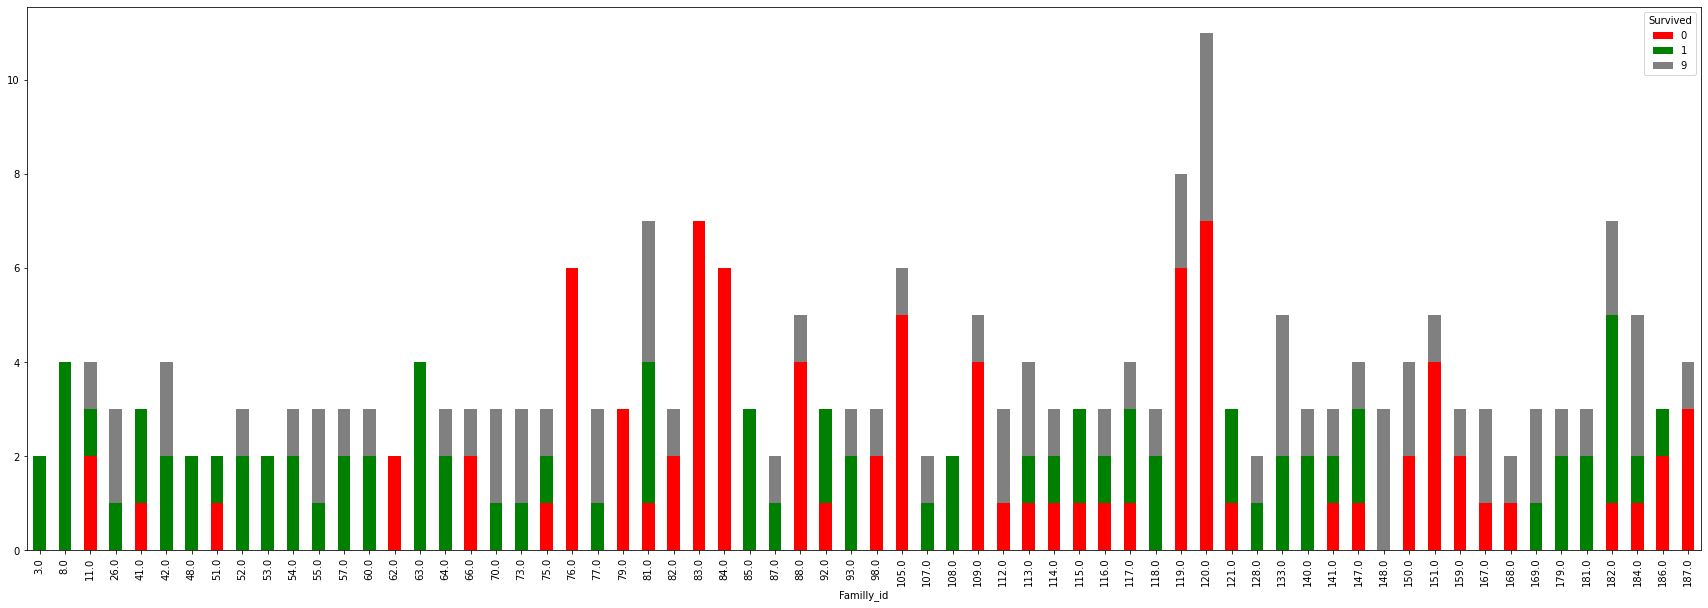

In [118]:
pd.crosstab(chld['Familly_id'], chld['Survived']).plot(kind='bar', stacked=True, color=['r','g','grey'], figsize=(30,10))
plt.show()

Big familly (up to 4 people) => more likely to all died maybe they want to stay together

Small familly tend to all survived or just the men died

#### Connected survival


In [119]:
df_full['Connected_Survival'] = df_full.groupby(['Familly_id'])['Survived'].transform('median')

In [120]:
df_full.loc[df_full['Alone']==1, 'Connected_Survival'] = 0.5
df_full.loc[df_full['Connected_Survival']== 5 , 'Connected_Survival'] = 0.5
df_full.loc[df_full['Connected_Survival']== 4.5, 'Connected_Survival'] = 0.5
df_full.loc[df_full['Connected_Survival']== 9, 'Connected_Survival'] = 0.5

In [121]:
df_full['Connected_Survival'].value_counts()

0.50    1027
1.00     170
0.00     112
Name: Connected_Survival, dtype: int64

In [122]:
df_full.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Alone,group_size,Couple,Title_High,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Survived,Familly_id,PassengerId,Embarked_C,Embarked_Q,Embarked_S,Familly_wt_chld,Connected_Survival
0,3,1,22.00,1,0,7.25,0,2,0,0,0,0,1,0,0,154.00,1,0,0,1,0.00,0.00
1,1,0,38.00,1,0,71.28,0,2,1,0,0,0,0,1,1,130.00,2,1,0,0,0.00,0.50
2,3,0,26.00,0,0,7.92,1,0,0,0,0,1,0,0,1,0.00,3,0,0,1,0.00,0.50
3,1,0,35.00,1,0,53.10,0,2,1,0,0,0,0,1,1,13.00,4,0,0,1,0.00,0.50
4,3,1,35.00,0,0,8.05,1,0,0,0,0,0,1,0,0,0.00,5,0,0,1,0.00,0.50


In [123]:
df_full.iloc[:len(df_train)].drop(['Familly_id', 'PassengerId'], axis = 1).head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Alone,group_size,Couple,Title_High,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Survived,Embarked_C,Embarked_Q,Embarked_S,Familly_wt_chld,Connected_Survival
0,3,1,22.00,1,0,7.25,0,2,0,0,0,0,1,0,0,0,0,1,0.00,0.00
1,1,0,38.00,1,0,71.28,0,2,1,0,0,0,0,1,1,1,0,0,0.00,0.50
2,3,0,26.00,0,0,7.92,1,0,0,0,0,1,0,0,1,0,0,1,0.00,0.50
3,1,0,35.00,1,0,53.10,0,2,1,0,0,0,0,1,1,0,0,1,0.00,0.50
4,3,1,35.00,0,0,8.05,1,0,0,0,0,0,1,0,0,0,0,1,0.00,0.50


In [124]:
df_train = df_full.iloc[:len(df_train)].drop(['Familly_id', 'PassengerId'], axis = 1)
df_test = df_full.iloc[len(df_train):].drop(['Familly_id', 'PassengerId'], axis = 1)

# Modeling

### Preprocessing

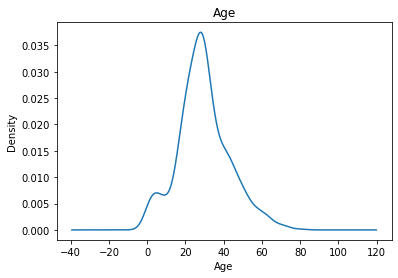

In [125]:
df_train.Age.plot(kind='kde')
plt.title('Age')
plt.xlabel('Age')
plt.show()

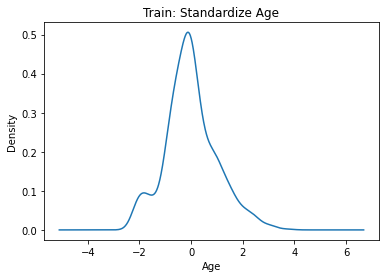

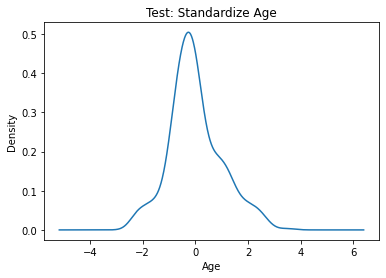

In [126]:
scaler = StandardScaler()

df_train['Age'] = scaler.fit_transform(df_train[['Age']])
df_test['Age'] = scaler.fit_transform(df_test[['Age']])


df_train['Age'].plot(kind='kde')
plt.title('Train: Standardize Age')
plt.xlabel('Age')
plt.show()


df_test['Age'].plot(kind='kde')
plt.title('Test: Standardize Age')
plt.xlabel('Age')
plt.show()

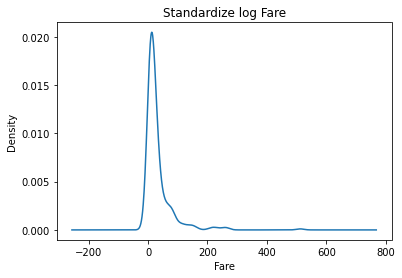

In [127]:
df_train.Fare.plot(kind='kde')
plt.title('Standardize log Fare')
plt.xlabel('Fare')
plt.show()

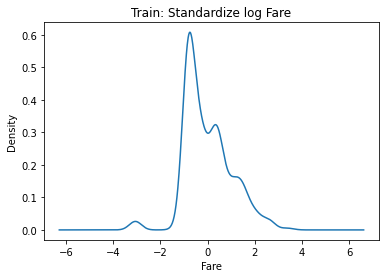

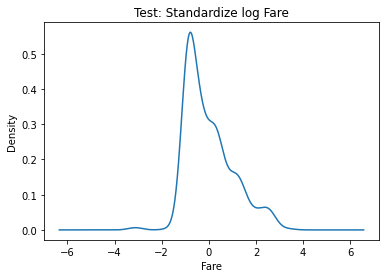

In [128]:
transformer = FunctionTransformer(np.log1p, validate=True)

df_train['Fare'] = scaler.fit_transform(transformer.transform(df_train[['Fare']]))
df_test['Fare'] = scaler.fit_transform(transformer.transform(df_test[['Fare']]))

df_train['Fare'].plot(kind='kde')
plt.title('Train: Standardize log Fare')
plt.xlabel('Fare')
plt.show()


df_test['Fare'].plot(kind='kde')
plt.title('Test: Standardize log Fare')
plt.xlabel('Fare')
plt.show()


In [129]:
df_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Alone,group_size,Couple,Title_High,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Survived,Embarked_C,Embarked_Q,Embarked_S,Familly_wt_chld,Connected_Survival
0,3,1,-0.56,1,0,-0.88,0,2,0,0,0,0,1,0,0,0,0,1,0.00,0.00
1,1,0,0.63,1,0,1.36,0,2,1,0,0,0,0,1,1,1,0,0,0.00,0.50
2,3,0,-0.26,0,0,-0.80,1,0,0,0,0,1,0,0,1,0,0,1,0.00,0.50
3,1,0,0.40,1,0,1.06,0,2,1,0,0,0,0,1,1,0,0,1,0.00,0.50
4,3,1,0.40,0,0,-0.78,1,0,0,0,0,0,1,0,0,0,0,1,0.00,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,1,-0.19,0,0,-0.33,1,0,0,1,0,0,0,0,0,0,0,1,0.00,0.50
887,1,0,-0.78,0,0,0.49,1,0,0,0,0,1,0,0,1,0,0,1,0.00,0.50
888,3,0,-1.60,1,2,0.24,0,4,0,0,0,1,0,0,0,0,0,1,1.00,0.50
889,1,1,-0.26,0,0,0.49,1,0,0,0,0,0,1,0,1,1,0,0,0.00,0.50


### Feature selection

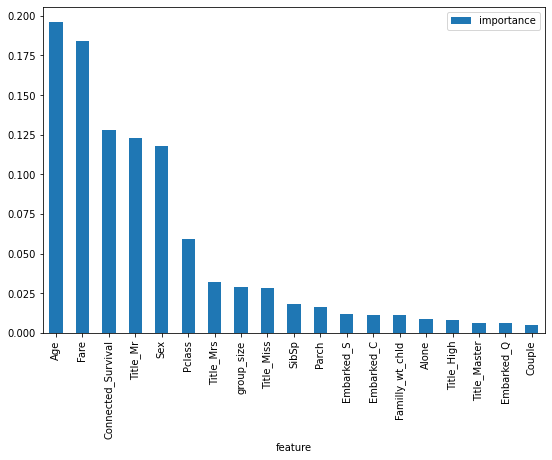

In [130]:
X = df_train.drop('Survived', axis=1)
y = df_train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = RandomForestClassifier(n_estimators=200, random_state=2)


model.fit(X_train,y_train)
importance = pd.DataFrame({'feature':X_train.columns, 'importance': np.round(model.feature_importances_,3)}).sort_values('importance', ascending=False).set_index('feature')
importance.plot(kind='bar', rot=90, figsize=(9,6))
plt.show()

In [131]:
importance.index

Index(['Age', 'Fare', 'Connected_Survival', 'Title_Mr', 'Sex', 'Pclass',
       'Title_Mrs', 'group_size', 'Title_Miss', 'SibSp', 'Parch', 'Embarked_S',
       'Embarked_C', 'Familly_wt_chld', 'Alone', 'Title_High', 'Title_Master',
       'Embarked_Q', 'Couple'],
      dtype='object', name='feature')

In [132]:
selected_cols = ['Age', 'Fare', 'Connected_Survival', 'Title_Mr', 'Sex', 'Pclass',
       'Title_Mrs', 'group_size', 'Title_Miss', 'Title_High', 'Title_Master','Survived']

In [133]:
df_train = df_train[selected_cols]
df_test = df_test[selected_cols]

### Model selection

In [134]:
X = df_train.drop('Survived', axis=1)
y = df_train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [135]:
clf = LazyClassifier(ignore_warnings=False, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

 14%|█▍        | 4/29 [00:00<00:02, 10.88it/s]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


 83%|████████▎ | 24/29 [00:01<00:00, 18.28it/s]

StackingClassifier model failed to execute
__init__() missing 1 required positional argument: 'estimators'


100%|██████████| 29/29 [00:02<00:00, 14.48it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LabelPropagation                   0.88               0.87     0.87      0.88   
LabelSpreading                     0.88               0.87     0.87      0.88   
LinearSVC                          0.87               0.86     0.86      0.87   
RidgeClassifierCV                  0.87               0.86     0.86      0.87   
CalibratedClassifierCV             0.87               0.86     0.86      0.87   
RidgeClassifier                    0.87               0.86     0.86      0.87   
LogisticRegression                 0.87               0.86     0.86      0.87   
LinearDiscriminantAnalysis         0.87               0.86     0.86      0.87   
LGBMClassifier                     0.86               0.85     0.85      0.86   
SGDClassifier                      0.87               0.85     0.85      0.86   
RandomForestClassifier      

### Model tuning: Grid search


Model selected: LGBMClassifier, XGBClassifier, AdaBoostClassifier, LogisticRegression, SVC, RandomForestClassifier, Decision Tree
,KNeighborsClassifier

In [136]:
def grid_test(model_name, model, parameters, X=X, y=y):
  
  model = GridSearchCV(
    model, 
    parameters, 
    cv=5,
    scoring='accuracy',
)
  
  model.fit(X, y)
  # y_pred = model.predict(X_test)

  # Mean cross-validated score of the best_estimator
  print(model_name, ': ', model.best_score_, '\n')
  # print(classification_report(y_test, y_pred),'\n')


  # return model_name, round(accuracy_score(y_test, y_pred)*100, 2), model.best_estimator_
  return model_name, model.best_score_, model.best_estimator_



In [137]:
# good
lgbm_param = {
    'n_estimators': [5, 10, 15, 25, 50, 100, 125, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [7, 15, 31],
}

# good
log_reg_param = {
    "penalty": ["l1", "l2"],

}

# good
xgb_param = {
    'max_depth': [3, 5, 7, 9], 
    'n_estimators': [5, 10, 15, 20, 25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1]
}

# good
ada_param = {
    'n_estimators': [70, 100, 150, 200, 250,300, 400],
    'learning_rate': [0.01, 0.05, 0.1]
}

# good
svc_param = {
    "C": [0.001, 0.01, 0.1, 0.5, 1.],
    "kernel": ["linear", "poly", "rbf", "sigmoid"]
}

# good
knn_param = {
    'n_neighbors':[5, 10, 15, 20, 25],
    "weights": ["uniform", "distance"]
}

# good
rf_param = {
    "n_estimators": [5, 10, 15, 20, 25], 
    "max_depth": [3, 5, 7, 9, 11, 13]
}

# good
d_tree_param =  {
    "max_depth": [3, 5, 7, 9, 11, 13]
}

In [138]:
# lgbm = LGBMClassifier(random_state= 42)
log_reg = LogisticRegression(random_state= 42)
xgb = xgboost.XGBClassifier(random_state=42)
ada = AdaBoostClassifier(random_state=42)
svc = SVC(random_state=42)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=42)
d_tree =  DecisionTreeClassifier(random_state=42)

models = [('LogisticRegression',log_reg, log_reg_param), ('XGBClassifier',xgb, xgb_param), 
          ('AdaBoostClassifier',ada, ada_param), ('SVC',svc, svc_param), ('KNeighborsClassifier',knn, knn_param), 
          ('RandomForestClassifier',rf, rf_param), ('Decision Tree',d_tree, d_tree_param) ]

In [139]:
acc_dic={}
model_dic={}


for model in models:
  name,acc, best_model = grid_test(model[0],model[1],model[2])
  acc_dic[name] = acc
  model_dic[name] = best_model

LogisticRegression :  0.8608248069801018 

XGBClassifier :  0.8731466951227166 

AdaBoostClassifier :  0.8653191890025734 

SVC :  0.8596761031950285 

KNeighborsClassifier :  0.8327600276191074 

RandomForestClassifier :  0.8742765676981985 

Decision Tree :  0.852921976021593 



In [140]:
pd.DataFrame.from_dict(acc_dic, orient='index', columns=['Mean CV Accuracy']).sort_values(by='Mean CV Accuracy', ascending=False)

,Mean CV Accuracy
RandomForestClassifier,0.87
XGBClassifier,0.87
AdaBoostClassifier,0.87
LogisticRegression,0.86
SVC,0.86
Decision Tree,0.85
KNeighborsClassifier,0.83


#### Model testing

In [141]:
pred_dic = {}

for tp in list(model_dic.items()):

  y_pred = tp[1].predict(X_test)

  pred_dic[tp[0]] = y_pred


  print(tp[0])
  print(classification_report(y_pred, y_test), '\n\n')

LogisticRegression
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       140
           1       0.80      0.86      0.83        83

    accuracy                           0.87       223
   macro avg       0.85      0.86      0.86       223
weighted avg       0.87      0.87      0.87       223
 


XGBClassifier
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       142
           1       0.82      0.90      0.86        81

    accuracy                           0.89       223
   macro avg       0.88      0.89      0.89       223
weighted avg       0.90      0.89      0.89       223
 


AdaBoostClassifier
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       141
           1       0.80      0.87      0.83        82

    accuracy                           0.87       223
   macro avg       0.86      0.87      0.86       223
weighted avg    



**Aggregate all models predictions**

In [142]:
df_pred = pd.DataFrame(pred_dic)
df_pred.head()

,LogisticRegression,XGBClassifier,AdaBoostClassifier,SVC,KNeighborsClassifier,RandomForestClassifier,Decision Tree
0,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1


In [143]:
y_pred = np.round(df_pred.apply(sum, axis=1) / df_pred.shape[1]).astype(int)
print(classification_report(y_pred, y_test), '\n\n')

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       138
           1       0.85      0.89      0.87        85

    accuracy                           0.90       223
   macro avg       0.89      0.90      0.90       223
weighted avg       0.90      0.90      0.90       223
 




**Deep Learning**

2023-02-14 10:46:23.545030: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-02-14 10:46:23.682274: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
668/668 [==============================] - 3s 3ms/step - loss: 0.5613 - accuracy: 0.7201 - val_loss: 0.4404 - val_accuracy: 0.8161
Epoch 2/30
668/668 [==============================] - 2s 2ms/step - loss: 0.4307 - accuracy: 0.8323 - val_loss: 0.3987 - val_accuracy: 0.8341
Epoch 3/30
668/668 [==============================] - 2s 2ms/step - loss: 0.3831 - accuracy: 0.8563 - val_loss: 0.3595 - val_accuracy: 0.8475
Epoch 4/30
668/668 [==============================] - 2s 2ms/step - loss: 0.3642 - accuracy: 0.8668 - val_loss: 0.3584 - val_accuracy: 0.8520
Epoch 5/30
668/668 [==============================] - 2s 3ms/step - loss: 0.3507 - accuracy: 0.8623 - val_loss: 0.3593 - val_accuracy: 0.8610
Epoch 6/30
668/668 [==============================] - 2s 3ms/step - loss: 0.3454 - accuracy: 0.8653 - val_loss: 0.3413 - val_accuracy: 0.8655
Epoch 7/30
668/668 [==============================] - 2s 3ms/step - loss: 0.3382 - accuracy: 0.8638 - val_loss: 0.3492 - val_accuracy: 0.8565
Epoch 

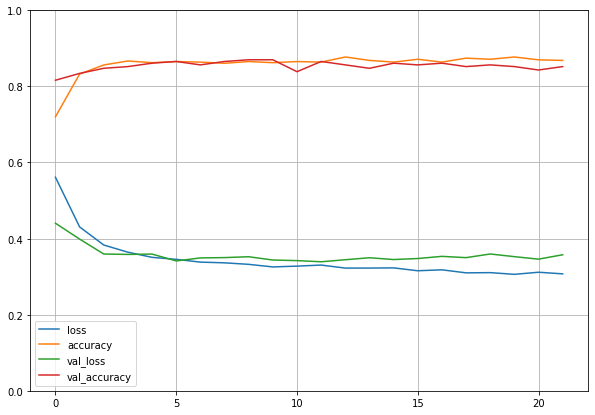

              precision    recall  f1-score   support

         0.0       0.93      0.86      0.89       144
         1.0       0.78      0.87      0.82        79

    accuracy                           0.87       223
   macro avg       0.85      0.87      0.86       223
weighted avg       0.87      0.87      0.87       223



In [144]:
import tensorflow as tf
from tensorflow import keras

checkpoint_cb = keras.callbacks.ModelCheckpoint('keras_model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

model = keras.Sequential([
                          keras.layers.Flatten(),
                          keras.layers.Dense(32, activation="relu"),
                          keras.layers.Dense(16, activation="relu"),
                          keras.layers.Dense(1, activation="sigmoid"),
])

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs =30, batch_size=1, callbacks=[checkpoint_cb, early_stopping_cb] ,validation_data = (X_test, y_test))

pd.DataFrame(history.history).plot(figsize = (10,7))
plt.grid(True)
plt.ylim(0,1)
plt.show()


model = keras.models.load_model('keras_model.h5')

y_pred = np.round(model.predict(X_test))

print(classification_report(y_pred, y_test))




**Conclusion** : Random Forest is the best model


# Submission

In [145]:
# top 4% 
rf_model = model_dic['RandomForestClassifier']

submission = pd.concat([pd.Series(df_test.index+1, name='PassengerId'), pd.Series(rf_model.predict(df_test.drop('Survived', axis=1)), name='Survived')], axis=1)

submission.to_csv('submission.csv', index=False)